In [1]:
import warnings
warnings.filterwarnings('ignore')

### Modelos preentrenados de Keras

En un principio se probarán 3 modelos.

    - VGG-16
    - Inception V3
    - ResNet 50

In [2]:
from keras.applications import VGG16
from keras.applications import InceptionV3
from keras.applications import ResNet50V2

from keras.applications.vgg16 import preprocess_input as vgg16_preprocessor
from keras.applications.inception_v3 import preprocess_input as inception_v3_preprocessor
from keras.applications.resnet_v2 import preprocess_input as resnet_v2_preprocessor


from keras.models import clone_model
from keras.models import Model
from keras.preprocessing import image


from IPython.display import clear_output
from tqdm import tqdm


models_dict = {}
vgg16_dict, inception_v3_dict, resnet50_dict = {} ,{} ,{}


print("Loading VGG16")
model = VGG16(weights='imagenet')
model = Model(model.input, model.layers[-2].output) # output_shape de la penúltima capa(fully-connected) -> (,4096)
vgg16_dict["model"] = clone_model(model)
vgg16_dict["preprocesor"] = vgg16_preprocessor
vgg16_dict["target_size"] = model.input_shape[1], model.input_shape[2]# default vgg16 input (224,224)


print("Loading Inception v3")
model = InceptionV3(weights='imagenet')
model = Model(model.input, model.layers[-2].output)# output_shape de la penúltima capa(pooling) -> (,2048)
inception_v3_dict["model"] = clone_model(model)
inception_v3_dict["preprocesor"] = inception_v3_preprocessor
inception_v3_dict["target_size"] = model.input_shape[1],model.input_shape[2] # default inceptionv3 input (299,299)


print("Loading ResNet 50")
model = ResNet50V2(weights='imagenet')
model = Model(model.input, model.layers[-2].output)# output_shape de la penúltima capa(pooling) -> (,2048)
resnet50_dict["model"] = clone_model(model)
resnet50_dict["preprocesor"] = resnet_v2_preprocessor
resnet50_dict["target_size"] = model.input_shape[1],model.input_shape[2]# default ResNet input (224,224)


# diccionarios de los 3 modelos, clave -> nombre, valor -> otro diccionario
models_dict["VGG16"] = vgg16_dict
models_dict["InceptionV3"] = inception_v3_dict
models_dict["ResNet50"] = resnet50_dict

clear_output()

In [3]:
import os
import cv2
import numpy as np
from keras.preprocessing import image
from skimage.io import imsave
import uuid

import matplotlib.pyplot as plt

def extract_features(image_path,model_name):
    '''
    model_name extaerá los features de la imagen que se le pase como parámetro.
    '''
    model_dict = models_dict[model_name]
    ####
    model = model_dict["model"]
    preprocessor = model_dict["preprocesor"]
    target_size = model_dict["target_size"]
    # se carga la imagen y después se ajusta al input shape del modelo
    img = cv2.resize(cv2.imread(image_path),target_size)

    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocessor(img_data)
    
    # extracción de features
    features = model.predict(img_data)
    return features[0]

In [4]:
def get_paths(directory):
    '''
    Devuelve la ruta relativa de las muestras .bmp
    '''
    paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".bmp"):
                paths.append(os.path.join(root, file))
    return paths

In [5]:
# paths de las muestra polarizadas
images = get_paths("CASIA-Polar")

In [6]:
for model_name in models_dict:
    print(model_name)

VGG16
InceptionV3
ResNet50


### Extracción de features de una sola muestra

Demo para comprobar que los 3 modelos extraen los features correctamente.

In [7]:
# features con modelo VGG16
feat_16 = extract_features(images[0],"VGG16")
print(feat_16.shape, feat_16[:10])

(4096,) [0.32080793 0.         0.         0.         0.         0.
 0.2236609  0.         0.         0.        ]


In [8]:
# features con modelo InceptionV3
feat_inceptionV3 = extract_features(images[0],"InceptionV3")
print(feat_inceptionV3.shape, feat_inceptionV3[:10])

(2048,) [1.1058461e-03 2.5456637e-05 0.0000000e+00 8.1461389e-05 0.0000000e+00
 7.0726164e-05 0.0000000e+00 9.3734975e-04 2.4920157e-03 2.3856848e-03]


In [9]:
# features con modelo ResNet
feat_r50 = extract_features(images[0],"ResNet50")
print(feat_r50.shape, feat_r50[:10])

(2048,) [0.06257685 0.         0.02554005 0.00038583 0.03880102 0.06238473
 0.         0.02474228 0.07609383 0.00310162]


In [10]:
import pandas as pd

# cargamos csv con los datos de las muestras
df = pd.read_csv("iris_data.csv", index_col=0) # quitamos columna unnamed

# cambiamos nombre de columnas para evitar conflictos con palabras reservadas de Pytho
df.rename(columns={'image':'Image','class':'Clase'}, inplace=True)
df.head()

,Image,pupil x_center,pupil y_center,pupil radius,iris x_center,iris y_center,iris radius,Clase
0,Adrianna_1.bmp,182,134,36,177,134,102,Adrianna
1,Adrianna_2.bmp,174,138,38,172,138,38,Adrianna
2,Adrianna_3.bmp,173,120,38,167,120,104,Adrianna
3,Adrianna_4.bmp,183,122,40,185,122,38,Adrianna
4,Adrianna_5.bmp,177,145,38,179,143,36,Adrianna


In [11]:
def register_to_deepfeatures(register):
    """
    Compute all CNN features    
    
    Parameters
    ----------
    register : Series
        Serie containing metadata of the image
   
    Returns
    -------
    results : Series 
        A Pandas Serie contanining all of the features

    """
    img_name = register.Image # nombre de la muestra e.g: Rafael_1.bmp
    clase = register.Clase # clase e.g Rafael
    
    img_dir = os.path.join("CASIA-Polar",clase)
    img_path = os.path.join(img_dir,img_name) # ruta completa de la muestra

    basic_values = pd.Series([img_name,clase],["Name","Class"])

    all_features = []
    all_names = []
    models = models_dict.keys() # 3 modelos
    
    for model in models:
        features = extract_features(img_path,model)
        names = [f"{model}_{i}" for i in range(len(features))]
        all_features+=list(features)
        all_names+= names
        
    results = pd.Series(all_features,all_names)
    return pd.concat((basic_values,results))


In [12]:
# probamos con una fila del dataframe
example1 = df.iloc[5]
example1

Image             Adrianna_6.bmp
pupil x_center               178
pupil y_center               134
pupil radius                  38
iris x_center                179
iris y_center                132
iris radius                   40
Clase                   Adrianna
Name: 5, dtype: object

In [13]:
results = register_to_deepfeatures(example1)
results

Name             Adrianna_6.bmp
Class                  Adrianna
VGG16_0                0.257431
VGG16_1                       0
VGG16_2                       0
                      ...      
ResNet50_2043          0.017776
ResNet50_2044        0.00806365
ResNet50_2045         0.0165815
ResNet50_2046         0.0239884
ResNet50_2047         0.0479141
Length: 8194, dtype: object

In [14]:
# aplica la función a todas las FILAS del dataframe(parecido a map())
df_deep = df.apply(register_to_deepfeatures, axis=1)

In [15]:
import winsound
freq = 1500
dur = 1000

In [16]:
df_deep

,Name,Class,VGG16_0,VGG16_1,VGG16_2,VGG16_3,VGG16_4,VGG16_5,VGG16_6,VGG16_7,...,ResNet50_2038,ResNet50_2039,ResNet50_2040,ResNet50_2041,ResNet50_2042,ResNet50_2043,ResNet50_2044,ResNet50_2045,ResNet50_2046,ResNet50_2047
0,Adrianna_1.bmp,Adrianna,0.320808,0.0,0.0,0.0,0.0,0.0,0.223661,0.0,...,0.010978,0.084681,0.009460,0.001698,0.000824,0.019294,0.008362,0.017151,0.021741,0.044017
1,Adrianna_2.bmp,Adrianna,0.263421,0.0,0.0,0.0,0.0,0.0,0.190056,0.0,...,0.013321,0.083209,0.009626,0.002065,0.001616,0.017314,0.008078,0.016310,0.024199,0.043038
2,Adrianna_3.bmp,Adrianna,0.223616,0.0,0.0,0.0,0.0,0.0,0.237586,0.0,...,0.013591,0.082945,0.008541,0.001736,0.002282,0.014793,0.008303,0.017193,0.021877,0.043665
3,Adrianna_4.bmp,Adrianna,0.265647,0.0,0.0,0.0,0.0,0.0,0.196666,0.0,...,0.013110,0.082772,0.009293,0.002158,0.001709,0.014438,0.007038,0.016786,0.024429,0.042538
4,Adrianna_5.bmp,Adrianna,0.306439,0.0,0.0,0.0,0.0,0.0,0.257681,0.0,...,0.013480,0.087893,0.010313,0.001507,0.000270,0.017701,0.007559,0.016925,0.025844,0.045339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,Zion_3.bmp,Zion,0.122809,0.0,0.0,0.0,0.0,0.0,0.224416,0.0,...,0.011827,0.079711,0.007352,0.001251,0.002082,0.018045,0.006574,0.017508,0.023361,0.042222
752,Zion_4.bmp,Zion,0.118695,0.0,0.0,0.0,0.0,0.0,0.188830,0.0,...,0.011527,0.079637,0.006724,0.001095,0.001124,0.018072,0.007455,0.015230,0.020709,0.043037
753,Zion_5.bmp,Zion,0.141669,0.0,0.0,0.0,0.0,0.0,0.208112,0.0,...,0.011188,0.074016,0.005553,0.000972,0.002534,0.012593,0.007878,0.014421,0.024238,0.039429
754,Zion_6.bmp,Zion,0.167616,0.0,0.0,0.0,0.0,0.0,0.217544,0.0,...,0.011607,0.075409,0.007770,0.001472,0.001883,0.016567,0.007974,0.016171,0.022955,0.039287


In [17]:
# guardamos las features
df_deep.to_csv("iris_deep_features.csv")

-----------------------------------

-------------------------

In [18]:
import pandas as pd
data = pd.read_csv("iris_deep_features.csv",index_col=0)
data.head()


,Name,Class,VGG16_0,VGG16_1,VGG16_2,VGG16_3,VGG16_4,VGG16_5,VGG16_6,VGG16_7,...,ResNet50_2038,ResNet50_2039,ResNet50_2040,ResNet50_2041,ResNet50_2042,ResNet50_2043,ResNet50_2044,ResNet50_2045,ResNet50_2046,ResNet50_2047
0,Adrianna_1.bmp,Adrianna,0.320808,0.0,0.0,0.0,0.0,0.0,0.223661,0.0,...,0.010978,0.084681,0.009460,0.001698,0.000824,0.019294,0.008362,0.017151,0.021741,0.044017
1,Adrianna_2.bmp,Adrianna,0.263421,0.0,0.0,0.0,0.0,0.0,0.190056,0.0,...,0.013321,0.083209,0.009626,0.002065,0.001616,0.017314,0.008078,0.016310,0.024199,0.043038
2,Adrianna_3.bmp,Adrianna,0.223616,0.0,0.0,0.0,0.0,0.0,0.237586,0.0,...,0.013591,0.082945,0.008541,0.001736,0.002282,0.014793,0.008303,0.017193,0.021877,0.043665
3,Adrianna_4.bmp,Adrianna,0.265647,0.0,0.0,0.0,0.0,0.0,0.196666,0.0,...,0.013110,0.082772,0.009293,0.002158,0.001709,0.014438,0.007038,0.016786,0.024429,0.042538
4,Adrianna_5.bmp,Adrianna,0.306439,0.0,0.0,0.0,0.0,0.0,0.257681,0.0,...,0.013480,0.087893,0.010313,0.001507,0.000270,0.017701,0.007559,0.016925,0.025844,0.045339


In [19]:
data.shape

(756, 8194)

In [20]:
import pickle

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.pipeline import Pipeline

### Choose the right estimator

In [128]:
from sklearn.svm import LinearSVC, SVC # uno vs el resto
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# ensemble classifiers
from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import GradientBoostingClassifier

In [129]:
pretrained_models = ["VGG16","InceptionV3","ResNet50"]

In [130]:
# true labels
y = data.Class.values

In [131]:
vgg_cols = data.columns.str.startswith("VGG16")
inception_cols = data.columns.str.startswith("InceptionV3")
resnet_cols = data.columns.str.startswith("ResNet50")

In [132]:
vgg_X = data[data.columns[vgg_cols]].values
inception_X = data[data.columns[inception_cols]].values
resnet_X = data[data.columns[resnet_cols]].values

In [159]:
inception_X.shape

(756, 2048)

In [133]:
datasets = [(vgg_X,y), (inception_X,y), (resnet_X,y)]
datasets_names = pretrained_models.copy()

In [134]:
'''
Definition of the SVM parameter search
'''
import numpy as np
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid_svm = dict(gamma=gamma_range, C=C_range)
nested_cv = 5

grid_svm = GridSearchCV(SVC(), param_grid=param_grid_svm, cv=nested_cv)


In [135]:
'''
List of classifiers and their names included in the experimental study
'''

cls_names = ["SVM", "Nearest Neighbors", "LogisticRegression", "Random Forest"] #"Gradient Boosting Trees"]

classifiers = [ make_pipeline(StandardScaler(), SVC(kernel='linear')), #(StandardScaler(), grid_svm)
                make_pipeline(StandardScaler(), KNeighborsClassifier(3)),
                make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
                RandomForestClassifier(random_state=0, n_estimators=100),
#                 GradientBoostingClassifier(random_state=0, n_estimators=100)
                ]

### Validación cruzada para evaluar los clasificadores

In [136]:
def cross_validate_preds_model(X, y, model, num_folds):
        '''
        @author José F. Díez Pastor
        Perform cross validation with a model and a dataset (X and y),
        and returns the predictions to later obtain the measurements 
        you want
        
        Parameters
        ----------
        X: numpy.array
            Dataset (features)
        Y: numpy.array
            Dataset (Target)
        model: scikit_model
            model to be trained
        num_folds: int
            number of folds in the cross validation
        
        Return
        -------
        array 
            array of prediccions obtained using cross_validation
        '''
        print('\t'+str(model)[:20]+"...", end=' - ')
        preds = cross_val_predict(model,X,y,cv=num_folds)
        print('OK')
        
        return preds

def run_all_save(num_folds,filename):
    '''
    @author José F. Díez Pastor
    Perform cross validation with all models and datasets.
        
        
    Parameters
    ----------
    num_folds: int
        number of folds in the cross validation
    filename: string
        name of the file that stores the predictions obtained using crossvalidation
        
    Return
    -------
    
    ''' 
    
    all_preds = {}

    for dataset,dataset_name in tqdm(zip(datasets, datasets_names)):
        print(f"----------Pre-trained network: {dataset_name}-----------")
        X,y = dataset
        for model,cls_name in zip(classifiers,cls_names):
            print(f"-> {cls_name}")
            preds = cross_validate_preds_model(X, y, model, num_folds)
            all_preds[(dataset_name,cls_name)]=(y,preds)

    all_preds["cls_names"]=cls_names
    all_preds["dataset_names"]=datasets_names

    with open(filename, 'wb') as fp:
         pickle.dump(all_preds, fp)

In [137]:
obj_file = "evaluation_models.obj"

run_all_save(4,obj_file) # 4 folds (divisor de 756)
winsound.Beep(freq,dur)

0it [00:00, ?it/s]

----------Pre-trained network: VGG16-----------
-> SVM
	Pipeline(steps=[('st... - OK
-> Nearest Neighbors
	Pipeline(steps=[('st... - OK
-> LogisticRegression
	Pipeline(steps=[('st... - OK
-> Random Forest
	RandomForestClassifi... - 

1it [02:23, 143.77s/it]

OK
----------Pre-trained network: InceptionV3-----------
-> SVM
	Pipeline(steps=[('st... - OK
-> Nearest Neighbors
	Pipeline(steps=[('st... - OK
-> LogisticRegression
	Pipeline(steps=[('st... - OK
-> Random Forest
	RandomForestClassifi... - 

2it [04:35, 140.20s/it]

OK
----------Pre-trained network: ResNet50-----------
-> SVM
	Pipeline(steps=[('st... - OK
-> Nearest Neighbors
	Pipeline(steps=[('st... - OK
-> LogisticRegression
	Pipeline(steps=[('st... - OK
-> Random Forest
	RandomForestClassifi... - 

3it [06:31, 130.47s/it]

OK


In [138]:
import pickle

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [262]:
def get_results(filename):
    '''
    @author: José F. Diez Pastor
    Load the file with the predictions.
    Compute accuracy, confusion matrix and other measures.
        
        
    Parameters
    ----------
    filename: string
        name of the file that stores the predictions obtained using crossvalidation
        
    Return
    dictionary
        A dictionary of key:values that asociates the name
        of a measure or chart with the value
    -------
    
    ''' 

    with open(filename, 'rb') as fp:
        all_preds = pickle.load(fp)

    cls_names = all_preds.pop("cls_names")
    dataset_names = all_preds.pop("dataset_names")

    data_cls_pairs = list(all_preds.keys())
    data_cls_pairs.sort()

    results = {}


    acc_df = pd.DataFrame(index=dataset_names, columns=cls_names)

    ## A DataFrame is created to store the accuracy in each clase
    for dataset in dataset_names:
        results[(dataset,"acc")] = pd.DataFrame(columns=cls_names)


    for dataset_name,cls_name in tqdm(data_cls_pairs):
        #print(dataset_name,cls_name)
        y_true, y_pred = all_preds[(dataset_name,cls_name)]
        labels = list(np.unique(y_true))

        acc = accuracy_score(y_true, y_pred)
        # Fill accuracy dataframe
        acc_df.at[dataset_name,cls_name]=acc
        
        report = classification_report(y_true, y_pred, output_dict=True)
        report_df = pd.DataFrame(report).transpose()
        results[(dataset_name,cls_name,"report")] = report_df

    results["Acc"] = acc_df
    return results

In [263]:
results = get_results(obj_file)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 40.93it/s]


In [264]:
list(results.keys())

[('VGG16', 'acc'),
 ('InceptionV3', 'acc'),
 ('ResNet50', 'acc'),
 ('InceptionV3', 'LogisticRegression', 'report'),
 ('InceptionV3', 'Nearest Neighbors', 'report'),
 ('InceptionV3', 'Random Forest', 'report'),
 ('InceptionV3', 'SVM', 'report'),
 ('ResNet50', 'LogisticRegression', 'report'),
 ('ResNet50', 'Nearest Neighbors', 'report'),
 ('ResNet50', 'Random Forest', 'report'),
 ('ResNet50', 'SVM', 'report'),
 ('VGG16', 'LogisticRegression', 'report'),
 ('VGG16', 'Nearest Neighbors', 'report'),
 ('VGG16', 'Random Forest', 'report'),
 ('VGG16', 'SVM', 'report'),
 'Acc']

In [265]:
results["Acc"]

,SVM,Nearest Neighbors,LogisticRegression,Random Forest
VGG16,0.876984,0.730159,0.89418,0.748677
InceptionV3,0.891534,0.752646,0.919312,0.809524
ResNet50,0.849206,0.753968,0.884921,0.681217


In [266]:
precisions = {}
for i in results.keys():
    if i[-1] == "report":
        print(i,end=" -> ")
        print(results[i]["precision"][-3])
        precisions[results[i]["precision"][-3]] = i
highest_precision = precisions[max(precisions)]
highest_precision

('InceptionV3', 'LogisticRegression', 'report') -> 0.9193121693121693
('InceptionV3', 'Nearest Neighbors', 'report') -> 0.7526455026455027
('InceptionV3', 'Random Forest', 'report') -> 0.8095238095238095
('InceptionV3', 'SVM', 'report') -> 0.8915343915343915
('ResNet50', 'LogisticRegression', 'report') -> 0.8849206349206349
('ResNet50', 'Nearest Neighbors', 'report') -> 0.753968253968254
('ResNet50', 'Random Forest', 'report') -> 0.6812169312169312
('ResNet50', 'SVM', 'report') -> 0.8492063492063492
('VGG16', 'LogisticRegression', 'report') -> 0.8941798941798942
('VGG16', 'Nearest Neighbors', 'report') -> 0.7301587301587301
('VGG16', 'Random Forest', 'report') -> 0.7486772486772487
('VGG16', 'SVM', 'report') -> 0.876984126984127


('InceptionV3', 'LogisticRegression', 'report')

In [267]:
best_model = highest_precision[0]
best_classifier = highest_precision[1]
print(f"Best Precision: \n\t - Model: {best_model}\n\t - Classifier: {best_classifier}")

Best Precision: 
	 - Model: InceptionV3
	 - Classifier: LogisticRegression


Se procede a entrenar el mejor clasificador(el que nos ha dado una mayor precisión) con los `features` extraídos por InceptionV3.

In [268]:
from sklearn.model_selection import train_test_split
X, y = datasets[1] #datasets = [(vgg_X,y), (inception_X,y), (resnet_X,y)]

# Dividimos los datos en entranamiento (80%) y testeo dejando (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf = classifiers[2] # LogisticRegression

In [269]:
# entrenamos modelo con el dataset de entrenamiento
clf.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [270]:
# se pone a prueba la precisión del clasificador con el dataset reservado al testeo
clf.score(X_test, y_test)

0.9407894736842105

In [272]:
# guardamos el modelo
from joblib import dump, load

dump(clf, "logistic_clf_trained.pkl")

['logistic_clf_trained.pkl']

### Última etapa del reconocimiento: `Matching`

Para probarlo se ha de coger cualquier muestra del directorio __CASIA-Polar__

In [237]:
### Reconocer un sujeto
img = "Scarlett_3.bmp" # cambiar ruta a directorio CASIA-Polar
test_sample = extract_features(img, "InceptionV3")

In [238]:
print(test_sample.shape, test_sample[:10])

(2048,) [1.2423155e-03 2.8855497e-05 0.0000000e+00 6.4432847e-05 0.0000000e+00
 6.4888278e-05 0.0000000e+00 9.0501574e-04 2.7398805e-03 2.6134404e-03]


In [239]:
# cambiamos el shape para que los transforme a una fila
test_sample.shape = [1,2048]
test_sample.shape

(1, 2048)

Resultado de la predicción, el individuo es...

In [241]:
prediction = clf.predict(test_sample)
prediction

array(['Scarlett'], dtype=object)

In [242]:
prediction_prob = classifier.predict_proba(test_sample)
prediction_prob

array([[7.66853444e-07, 1.92894933e-09, 2.70332088e-04, 1.19147972e-04,
        7.12070807e-09, 4.06121531e-08, 3.95131667e-09, 6.63462319e-08,
        6.22699069e-08, 5.86392980e-10, 1.79734932e-05, 5.41870451e-12,
        2.99159121e-09, 1.00554318e-06, 1.92486991e-08, 1.69251031e-08,
        3.55642658e-10, 1.55599218e-12, 3.65041113e-05, 2.24630090e-06,
        1.82729483e-05, 4.13471163e-08, 2.51920556e-06, 1.03385034e-07,
        2.62589034e-05, 2.78450885e-07, 6.66049402e-06, 6.87139789e-06,
        1.54470971e-04, 1.05916027e-07, 3.56307980e-07, 7.18193672e-07,
        1.30132327e-07, 3.32592472e-07, 6.19817774e-11, 3.61909331e-07,
        5.15814536e-05, 5.37409009e-06, 7.46134163e-08, 1.41295975e-06,
        2.88852656e-09, 1.09595719e-07, 4.12416500e-05, 4.08495615e-06,
        4.51414498e-08, 1.57606383e-07, 2.75201235e-05, 1.96195499e-06,
        2.44369854e-11, 4.83376839e-10, 7.53992258e-10, 7.03641611e-05,
        7.35399564e-08, 1.13297541e-08, 1.30164937e-06, 3.846809

In [243]:
labels = np.unique(y) # 108 individuos

#juntamos individuos y la probabilidades
predicted_dict = dict(zip(prediction_prob[0], labels))

In [244]:
predicted_dict

{7.66853444177348e-07: 'Adrianna',
 1.9289493265205617e-09: 'Aharon',
 0.0002703320878111508: 'Aidan',
 0.00011914797171839954: 'Aiza',
 7.1207080672628864e-09: 'Aleah',
 4.0612153125932087e-08: 'Alice',
 3.951316665603113e-09: 'Alvin',
 6.634623193812347e-08: 'Amayah',
 6.226990689355661e-08: 'Amberly',
 5.863929799721477e-10: 'Aminata',
 1.7973493186072607e-05: 'Ananya',
 5.418704508785907e-12: 'Anas',
 2.9915912066736758e-09: 'Andrea',
 1.0055431772290298e-06: 'Andrew',
 1.9248699059953266e-08: 'Arlette',
 1.692510313999055e-08: 'Armaan',
 3.5564265826212087e-10: 'Arye',
 1.5559921825919361e-12: 'Ashton',
 3.650411131752097e-05: 'Atara',
 2.246300901856098e-06: 'Avery',
 1.8272948314564293e-05: 'Avital',
 4.134711627742455e-08: 'Axel',
 2.519205561898544e-06: 'Batsheva',
 1.0338503442082689e-07: 'Brendan',
 2.6258903374928507e-05: 'Brianny',
 2.7845088538101664e-07: 'Brucha',
 6.660494023980688e-06: 'Byron',
 6.871397886014567e-06: 'Camren',
 0.0001544709712350738: 'Carlos',
 1.0591

In [252]:
import heapq

# 5 individuos más probables 
top_five = heapq.nlargest(5, predicted_dict)
labels, probs = [], []
for k,v in predicted_dict.items():
    if k in top_five:
        print(v+" -> "+str(k)+"%")
        labels.append(v)
        probs.append(k)

Aidan -> 0.0002703320878111508%
Lindsay -> 0.00018586981129393076%
Mushka -> 0.0004592286546182661%
Rafael -> 0.0003725277416599258%
Scarlett -> 0.9977954928858253%


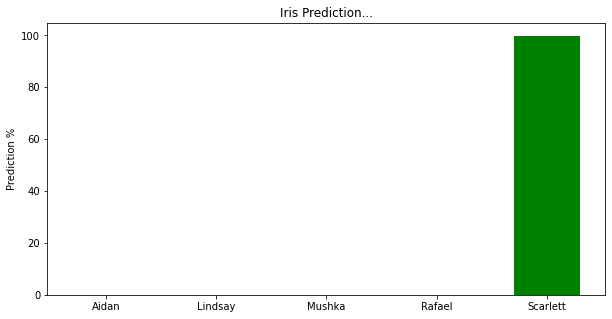

In [253]:
y_pos = np.arange(len(labels))
fig = plt.figure(figsize = (10,5))
plt.bar(labels, [i*100 for i in probs], color = 'green', width = 0.6)

plt.xticks(y_pos, labels)
plt.ylabel('Prediction %')
plt.title('Iris Prediction...')

plt.show()

In [261]:
modelo_cargado = load("logistic_clf_trained.pkl")
test_sample = extract_features("Imani_6.bmp", "InceptionV3")
test_sample.shape = [1,test_sample.shape[0]]
modelo_cargado.predict(test_sample)

array(['Imani'], dtype=object)